# Initialization

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import scipy 
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math
import time
import os
import sys
current_path = os.getcwd()
path_to_files = current_path + '/../sz_auxiliary_files/'



TCMB = 2.726 #Kelvin
TCMB_uK = 2.726e6 #micro-Kelvin


hplanck=6.626068e-34 #MKS
kboltz=1.3806503e-23 #MKS
clight=299792458.0 #MKS
m_elec = 510.999 #keV

# tsz function
def fsz(nu_ghz):
    nu = 1.e9*np.asarray(nu_ghz).astype(float)
    X = hplanck*nu/(kboltz*TCMB)
    resp = (X / np.tanh(X/2.0) - 4.0) * TCMB_uK #put explicitly into uK_CMB units,
    return resp
# sys.path.append('/Users/boris/Work/CLASS-SZ/SO-SZ/rancat/rancat')
# import cosmology as co

# import healpy as hp


common_settings = {
                   'mass function' : 'T08', 
                   'delta for cib' : '200m',
                   'hm_consistency': 0,
                   'concentration parameter': 'D08',  # Duffy et al 2008 
}

# copied from : https://github.com/simonsobs/websky_model/blob/a93bbf758432a936c0ec2b59775683b695d3d191/websky_model/websky.py#L55
websky_Omega_M = 0.31
websky_Omega_B = 0.049
websky_Omega_L = 0.69
websky_h = 0.68
websky_sigma_8 = 0.81
websky_n_s = 0.965


websky_cosmo = {
    'omega_b': websky_Omega_B*websky_h**2.,
    'omega_cdm': (websky_Omega_M-websky_Omega_B)*websky_h**2.,
    'h': websky_h,
    'tau_reio': 0.0543,
    'sigma8': websky_sigma_8,
    'n_s': websky_n_s, 
    'use_websky_m200m_to_m200c_conversion': 1
}


# parameters used by Fiona and Mat
cib_params = {
       'hm_consistency': 0,
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M_min' : 1e10*websky_cosmo['h'],
        'M_max' : 1e16*websky_cosmo['h'],
        'z_min' : 0.07,
        'z_max' : 6,
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
       'cib_frequency_list_num' : 1,
       'cib_frequency_list_in_GHz' : '353',   
    
}
tsz_params ={

       'pressure profile': 'B12',  # check source/input.c for default parameter values of Battaglia et al profile (B12)
       'units for tSZ spectrum': 'dimensionless',
       'n_ell_pressure_profile' : 100,
       'n_m_pressure_profile' : 100,
       'n_z_pressure_profile' : 100,
       'x_outSZ': 4.,
       'truncate_wrt_rvir':0,
       'pressure_profile_epsrel':1e-3,
       'pressure_profile_epsabs':1e-40,

}

# ~ model 2 of https://arxiv.org/pdf/1208.5049.pdf (Table 5)
# more exactly:
# shang_zplat  = 2.0
# shang_Td     = 20.7
# shang_beta   = 1.6
# shang_eta    = 1.28
# shang_alpha  = 0.2
# shang_Mpeak  = 10.**12.3
# shang_sigmaM = 0.3

# centrals is Ncen = 1 for all halos with mass bigger than websky's m_min
# subhalo mass function is eq. 3.9 of the websky paper 
# it is F. Jiang and F. C. van den Bosch, Generating merger trees for dark matter haloes: a comparison of
# methods, MNRAS 440 (2014) 193 [1311.5225].
websky_cib_params = {
       
       'Redshift evolution of dust temperature' :  0.2,
       'Dust temperature today in Kelvins' : 20.7,
       'Emissivity index of sed' : 1.6,
       'Power law index of SED at high frequency' : 1.7, # not given in WebSky paper, actually not relevant since we dont use high freqs in websky.
       'Redshift evolution of L − M normalisation' : 1.28,
       'Most efficient halo mass in Msun' : 10.**12.3,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 1e-7,  # not given in WebSky paper
       'Size of of halo masses sourcing CIB emission' : 0.3,
       'z_plateau_cib' : 2.,

        # M_min_HOD is the threshold above which nc = 1:
        # 'M_min_HOD' : 10.**10.1, # not used here
        'use_nc_1_for_all_halos_cib_HOD': 1,
    
        'sub_halo_mass_function' : 'JvdB14',
        'M_min_subhalo_in_Msun' : 1e11,
        'use_redshift_dependent_M_min': 1,
        #'full_path_to_redshift_dependent_M_min':'/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/websky_halo_mass_completion_z_Mmin_in_Msun_over_h.txt',
        #'M_min' : 1e10*websky_cosmo['h'], # not used
        'M_max' : 1e16*websky_cosmo['h'],
        'z_min' : 5e-3,
        'z_max' : 4.6,
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
       'cib_frequency_list_num' : 1,
       'cib_frequency_list_in_GHz' : '353',  
    
        #for the monopole computation:
        'freq_min': 2e1,
        'freq_max': 4e3,
        'dlogfreq' : 0.05,

# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        #'cib_Snu_cutoff_list [mJy]':'315',
        'has_cib_flux_cut': 0
}



font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)




# Plot websky CIB

Frequency list of websky's CIB map:

cib_freq_list = ['093','100','143','145','217','225','278','353','545','857']

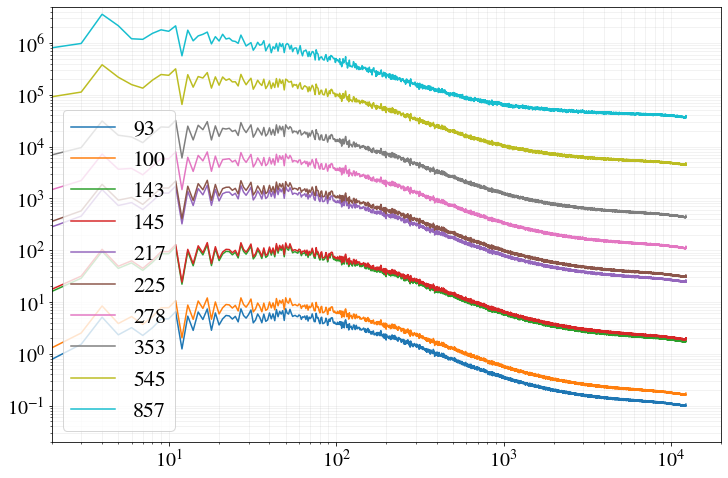

In [4]:
plt.figure(figsize=(12,8))

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_093_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='93')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_100_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='100')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_143_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='143')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_145_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='145')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='217')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_225_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='225')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_278_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='278')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_353_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='353')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_545_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='545')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_857_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,label='857')



plt.xscale('log')
plt.yscale('log')
plt.ylim(2e-2,5e6)
plt.xlim(2.,2.e4)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=22)

# Compute L0 normalization

In [8]:
M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.compute()
cl_cib_cib = M.cl_cib_cib()

CIB Monopole

to run following cell you need to download the fits file, I put here the result of this cell:<br>
I0_ws = [594856.1556067903,
 64879.56542025182,
 2737.335720859002,
 121945.91243144483,
 318038.8509457939,
 31888.804251634076,
 35482.62238960164,
 9195.66163207237,
 8796.859744645688,
 2149.0154765762395]

In [21]:
cib_freq_list = ['857','278','100','353','545','217','225','145','143','093']
nu_ws = []
I0_ws = []
for cib_freq in cib_freq_list:
    nu_ws.append(float(cib_freq))
    cib_map  =hp.read_map('/Users/boris/Work/CLASS-SZ/SO-SZ/websky_cib/cib_nu0'+cib_freq+'.fits')
    r = np.mean(cib_map)*1e6
    I0_ws.append(r)
    
    

/usr/local/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/usr/local/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/usr/local/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


## plot websky CIB monopole not normalized

In [9]:
cib_freq_list = ['857','278','100','353','545','217','225','145','143','093']
nu_ws = []
for cib_freq in cib_freq_list:
    nu_ws.append(float(cib_freq))
I0_ws = [594856.1556067903,
 64879.56542025182,
 2737.335720859002,
 121945.91243144483,
 318038.8509457939,
 31888.804251634076,
 35482.62238960164,
 9195.66163207237,
 8796.859744645688,
 2149.0154765762395]

[]

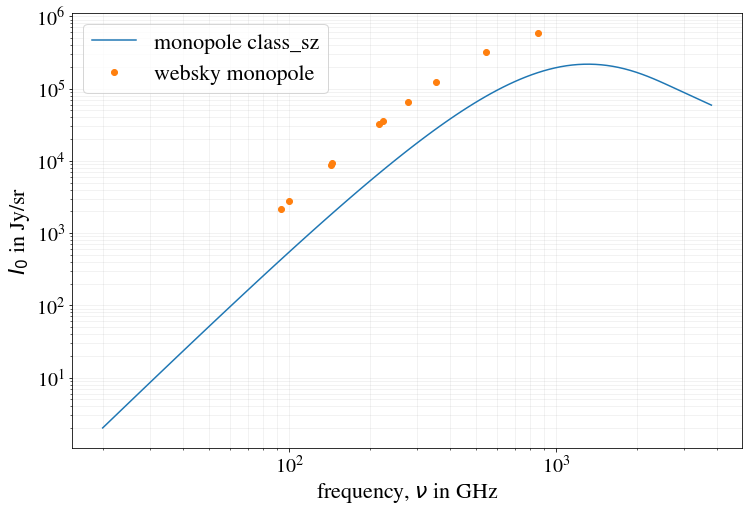

In [10]:
plt.figure(figsize=(12,8))
plt.plot(M.cib_monopole()['nu'],M.cib_monopole()['I0'],label=r'monopole class_sz')
plt.plot(nu_ws,I0_ws,marker='o',label='websky monopole',ls='None')
plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=22)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.loglog()

Find L0 such that the monopole is normalized:

In [11]:
print(nu_ws[3])
websky_monopole_353_in_Jy = I0_ws[3]


353.0


In [12]:

I0_ini_interp = scipy.interpolate.interp1d(M.cib_monopole()['nu'],M.cib_monopole()['I0'])
L0_websky = websky_monopole_353_in_Jy/I0_ini_interp(353)*1e-7
L0_websky

4.461102571695613e-07

## Recompute and plot cib with websky normalization

In [13]:
L0_websky = 4.461102571695613e-07

In [14]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
      })
M.compute()
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()

with flux cut:

In [15]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
#cib_Snu_1 = 315.
#cib_Snu_2 = 315.
        'cib_Snu_cutoff_list [mJy]':'315,350,225',
        'has_cib_flux_cut': 1
      })
M.compute()
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()

[]

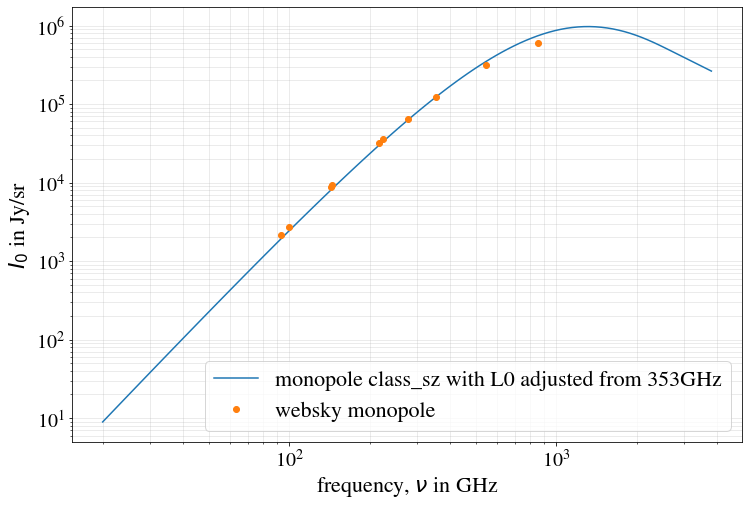

In [16]:
plt.figure(figsize=(12,8))
plt.plot(cib_monopole['nu'],cib_monopole['I0'],label=r'monopole class_sz with L0 adjusted from 353GHz')
plt.plot(nu_ws,I0_ws,marker='o',label='websky monopole',ls='None')
plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=22)
plt.loglog()

CIB Power spectra

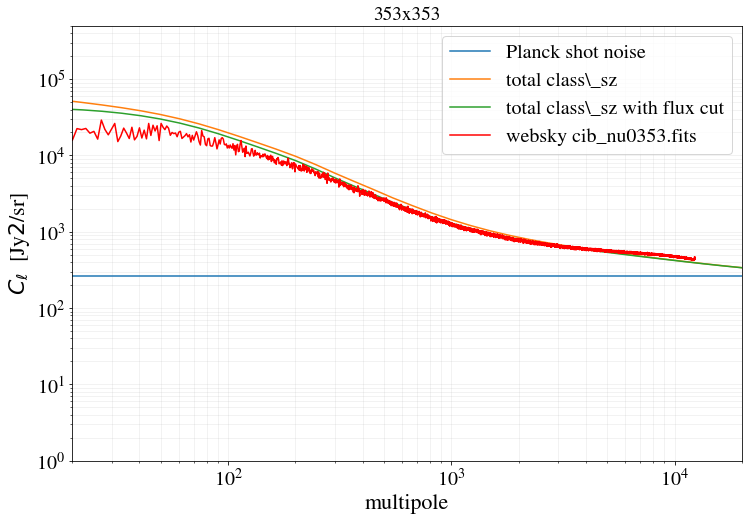

In [17]:
plt.figure(figsize=(12,8))


l_csz = np.asarray(cl_cib_cib['353x353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi

cls_csz_1h = np.asarray(cl_cib_cib['353x353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['353x353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['2h'])/cls_to_dls


planck_shot_noise = 262*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_353_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0353.fits')




plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


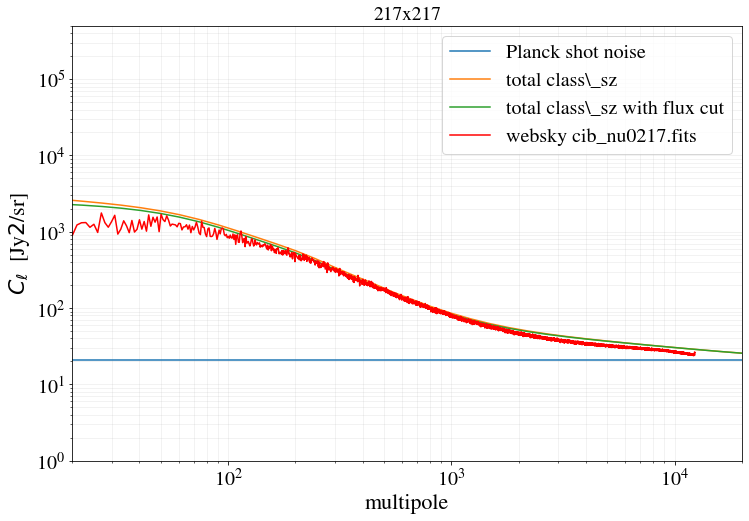

In [18]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['217x217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['217x217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['217x217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['2h'])/cls_to_dls

# plt.plot(l_csz,cls_csz_1h,c='k',label='class_sz 1h',ls='-.')
# plt.plot(l_csz,cls_csz_2h,c='k',label='class_sz 2h')

planck_shot_noise = 21.*l_csz/l_csz
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')

ls_ws,cls_ws = np.loadtxt(path_to_files+'cib_files/cl_cib_cib_217_websky_l_cl_090322.txt',unpack=True)
plt.plot(ls_ws,cls_ws*1e12,c='r',label='websky cib_nu0217.fits')


# l_fm,cls_fm_1h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_1h_353x353.txt',unpack=True)
# l_fm,cls_fm_2h = np.loadtxt('/Users/boris/Work/CLASS-SZ/SO-SZ/class_sz/sz_auxiliary_files/cib_files/cib_2h_353x353.txt',unpack=True)

# cls_fm_1h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# cls_fm_2h *= 1./(l_fm*(l_fm+1.)/2./np.pi) 
# plt.plot(l_fm,cls_fm_1h,lw=0.5,c='grey',ls='-.',label='Fiona+Mat 1h')
# plt.plot(l_fm,cls_fm_2h,lw=0.5,c='grey',label='Fiona+Mat 2h')



plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('217x217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


# Plot CIB from class_sz using websky model

## compute 

In [20]:
L0_websky = 4.461102571695613e-07

In [19]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h,tSZ_1h,tSZ_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
      })
M.compute()
cl_cib_cib = M.cl_cib_cib()
cib_monopole = M.cib_monopole()
cl_tsz_cib = M.cl_tSZ_cib()
cl_sz = M.cl_sz()

with flux cut:

In [21]:

M = Class()
M.set({'output':'cib_monopole,cib_cib_1h,cib_cib_2h,tSZ_cib_1h,tSZ_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       
       'cib_frequency_list_num' : 3,
       'cib_frequency_list_in_GHz' : '353,143,217',  
# table 1 of https://arxiv.org/pdf/1309.0382.pdf
#1: freq GHz 2: Flux cut mJy
# 100 - 400
# 143 - 350
# 217 - 225
# 353 - 315
# 545 - 350
# 857 - 710
# 3000  - 1000
        'cib_Snu_cutoff_list [mJy]':'315,350,225',
        'has_cib_flux_cut': 1
      })
M.compute()
cl_cib_cib_flux_cut = M.cl_cib_cib()
cib_monopole_flux_cut = M.cib_monopole()
cl_tsz_cib_flux_cut = M.cl_tSZ_cib()

## plot monopole

[]

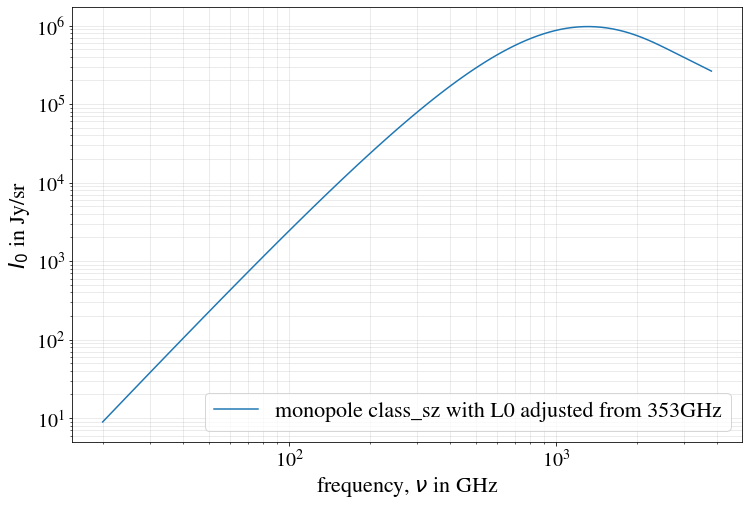

In [23]:
plt.figure(figsize=(12,8))
plt.plot(cib_monopole['nu'],cib_monopole['I0'],label=r'monopole class_sz with L0 adjusted from 353GHz')

plt.xlabel(r'frequency, $\nu$ in GHz',fontsize=22)
plt.ylabel(r'$I_0$ in Jy/sr',fontsize=22)
plt.grid(which='both',alpha=0.3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=22)
plt.loglog()

## plot tsz auto power spectrum

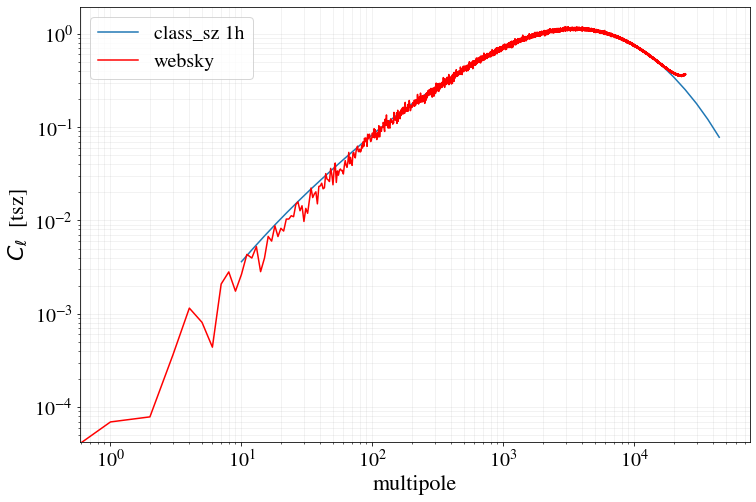

In [24]:
plt.figure(figsize=(12,8))

ls_ws,dls_ws = np.loadtxt(path_to_files+'websky_april_8192.txt',unpack=True)

plt.loglog(cl_sz['ell'],np.asarray(cl_sz['1h'])+0.*np.asarray(cl_sz['2h']),label='class_sz 1h')
plt.loglog(ls_ws,dls_ws*1e12,c='r',label='websky')
# plt.grid(which='both',alpha=0.2)
plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [tsz]',fontsize=22)
# plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)

## plot cib auto-power spectra

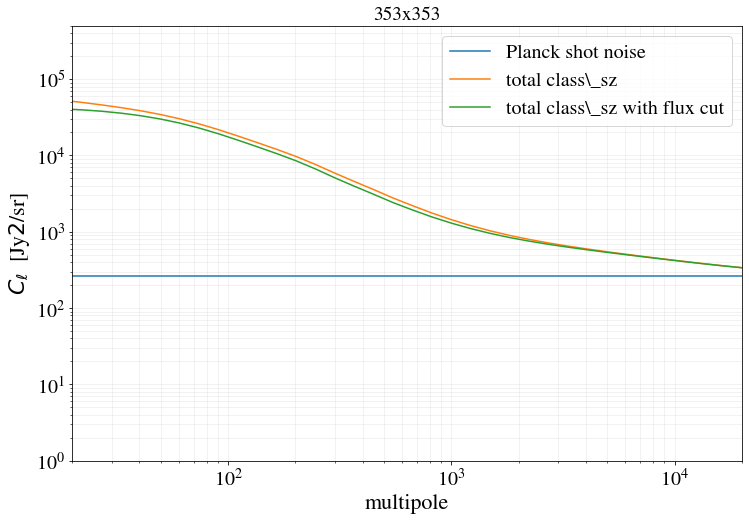

In [25]:
plt.figure(figsize=(12,8))


l_csz = np.asarray(cl_cib_cib['353x353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi

cls_csz_1h = np.asarray(cl_cib_cib['353x353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['353x353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['353x353']['2h'])/cls_to_dls


planck_shot_noise = 262*l_csz/l_csz # see table at the end of notebook
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')




plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('353x353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


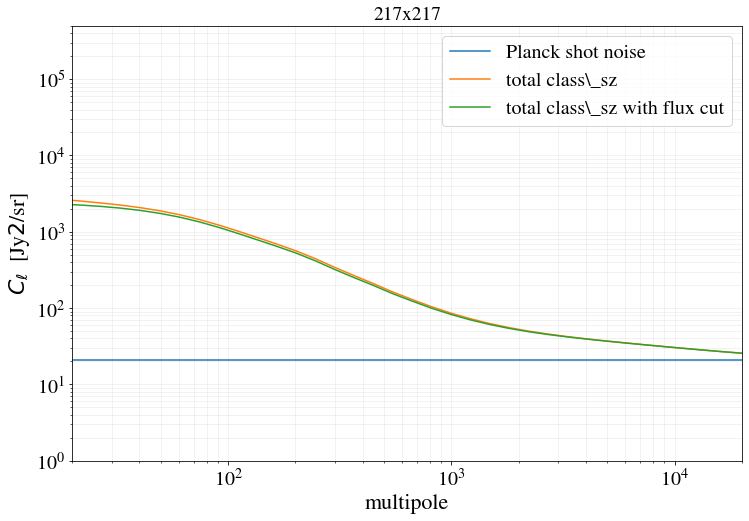

In [26]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_cib_cib['217x217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_cib_cib['217x217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_cib_cib['217x217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_cib_cib_flux_cut['217x217']['2h'])/cls_to_dls


planck_shot_noise = 21.*l_csz/l_csz # see table at the end of notebook
plt.plot(l_csz,planck_shot_noise,label='Planck shot noise')


plt.plot(l_csz,(cls_csz_1h+cls_csz_2h)+planck_shot_noise,label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut)+planck_shot_noise,label='total class\_sz with flux cut')




plt.loglog()
plt.xlim(20,2e4)
plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [Jy$2$/sr]',fontsize=22)
plt.title('217x217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


## plot cib - tsz cross power spectra

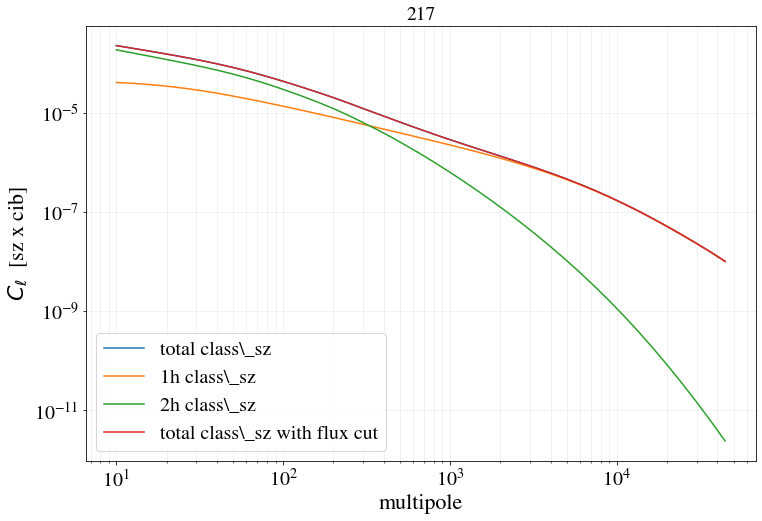

In [27]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_tsz_cib['217']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['217']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['217']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['217']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['217']['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h),label='1h class\_sz')
plt.plot(l_csz,(cls_csz_2h),label='2h class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label='total class\_sz with flux cut')




plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('217')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


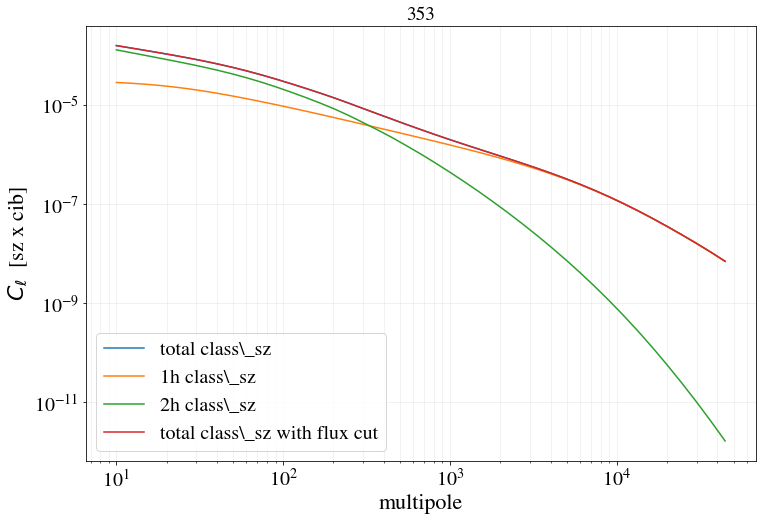

In [28]:
plt.figure(figsize=(12,8))

l_csz = np.asarray(cl_tsz_cib['353']['ell'])
cls_to_dls = l_csz*(l_csz+1.)/2./np.pi
cls_csz_1h = np.asarray(cl_tsz_cib['353']['1h'])/cls_to_dls
cls_csz_2h = np.asarray(cl_tsz_cib['353']['2h'])/cls_to_dls

cls_csz_1h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['353']['1h'])/cls_to_dls
cls_csz_2h_flux_cut = np.asarray(cl_tsz_cib_flux_cut['353']['2h'])/cls_to_dls



plt.plot(l_csz,(cls_csz_1h+cls_csz_2h),label='total class\_sz')
plt.plot(l_csz,(cls_csz_1h),label='1h class\_sz')
plt.plot(l_csz,(cls_csz_2h),label='2h class\_sz')
plt.plot(l_csz,(cls_csz_1h_flux_cut+cls_csz_2h_flux_cut),label='total class\_sz with flux cut')




plt.loglog()
# plt.xlim(20,2e4)
# plt.ylim(1,5e5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('multipole',fontsize=22)
plt.ylabel(r'$C_\ell$  [sz x cib]',fontsize=22)
plt.title('353')
plt.grid(which='both',alpha=0.2)
plt.legend(fontsize=20)


# CIB correlation

In [12]:
L0_websky = 4.461102571695613e-07
M = Class()
M.set({'output':'cib_cib_1h,cib_cib_2h'})
M.set(common_settings)
M.set(websky_cosmo)
M.set(websky_cib_params)
M.set(tsz_params)

M.set({'Normalisation of L − M relation in [Jy MPc2/Msun]' :L0_websky,
       
       'cib_frequency_list_num' : 2,
       'cib_frequency_list_in_GHz' : '220,857',  
      })
M.compute()
cl_cib_cib = M.cl_cib_cib()


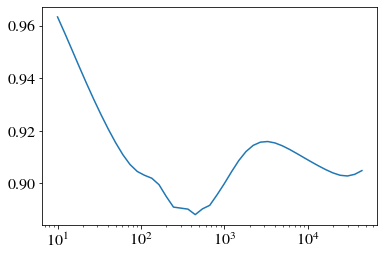

In [21]:
ell =  np.asarray(cl_cib_cib['857x857']['ell'])
cl_353_353 = np.asarray(cl_cib_cib['857x857']['1h'])+np.asarray(cl_cib_cib['857x857']['2h'])
cl_143_143 = np.asarray(cl_cib_cib['220x220']['1h'])+np.asarray(cl_cib_cib['220x220']['2h'])
cl_143_353 = np.asarray(cl_cib_cib['857x220']['1h'])+np.asarray(cl_cib_cib['857x220']['2h'])
plt.plot(ell,cl_143_353/np.sqrt((cl_353_353*cl_143_143)))
plt.xscale('log')

In [19]:
ell

array([1.00000000e+01, 1.22140276e+01, 1.49182470e+01, 1.82211880e+01,
       2.22554093e+01, 2.71828183e+01, 3.32011692e+01, 4.05519997e+01,
       4.95303242e+01, 6.04964746e+01, 7.38905610e+01, 9.02501350e+01,
       1.10231764e+02, 1.34637380e+02, 1.64446468e+02, 2.00855369e+02,
       2.45325302e+02, 2.99641000e+02, 3.65982344e+02, 4.47011845e+02,
       5.45981500e+02, 6.66863310e+02, 8.14508687e+02, 9.94843156e+02,
       1.21510418e+03, 1.48413159e+03, 1.81272242e+03, 2.21406416e+03,
       2.70426407e+03, 3.30299560e+03, 4.03428793e+03, 4.92749041e+03,
       6.01845038e+03, 7.35095189e+03, 8.97847292e+03, 1.09663316e+04,
       1.33943076e+04, 1.63598443e+04, 1.99819590e+04, 2.44060198e+04,
       2.98095799e+04, 3.64095031e+04, 4.44706675e+04])

# Some useful imported plots/tables and references

(Note that here the class_sz settings are not setup to reproduce Fiona+Mat's results, see at the end of the notebook for the benchmark comparison)

Here below is Fiona+Mat's plot from https://arxiv.org/pdf/2010.16405.pdf

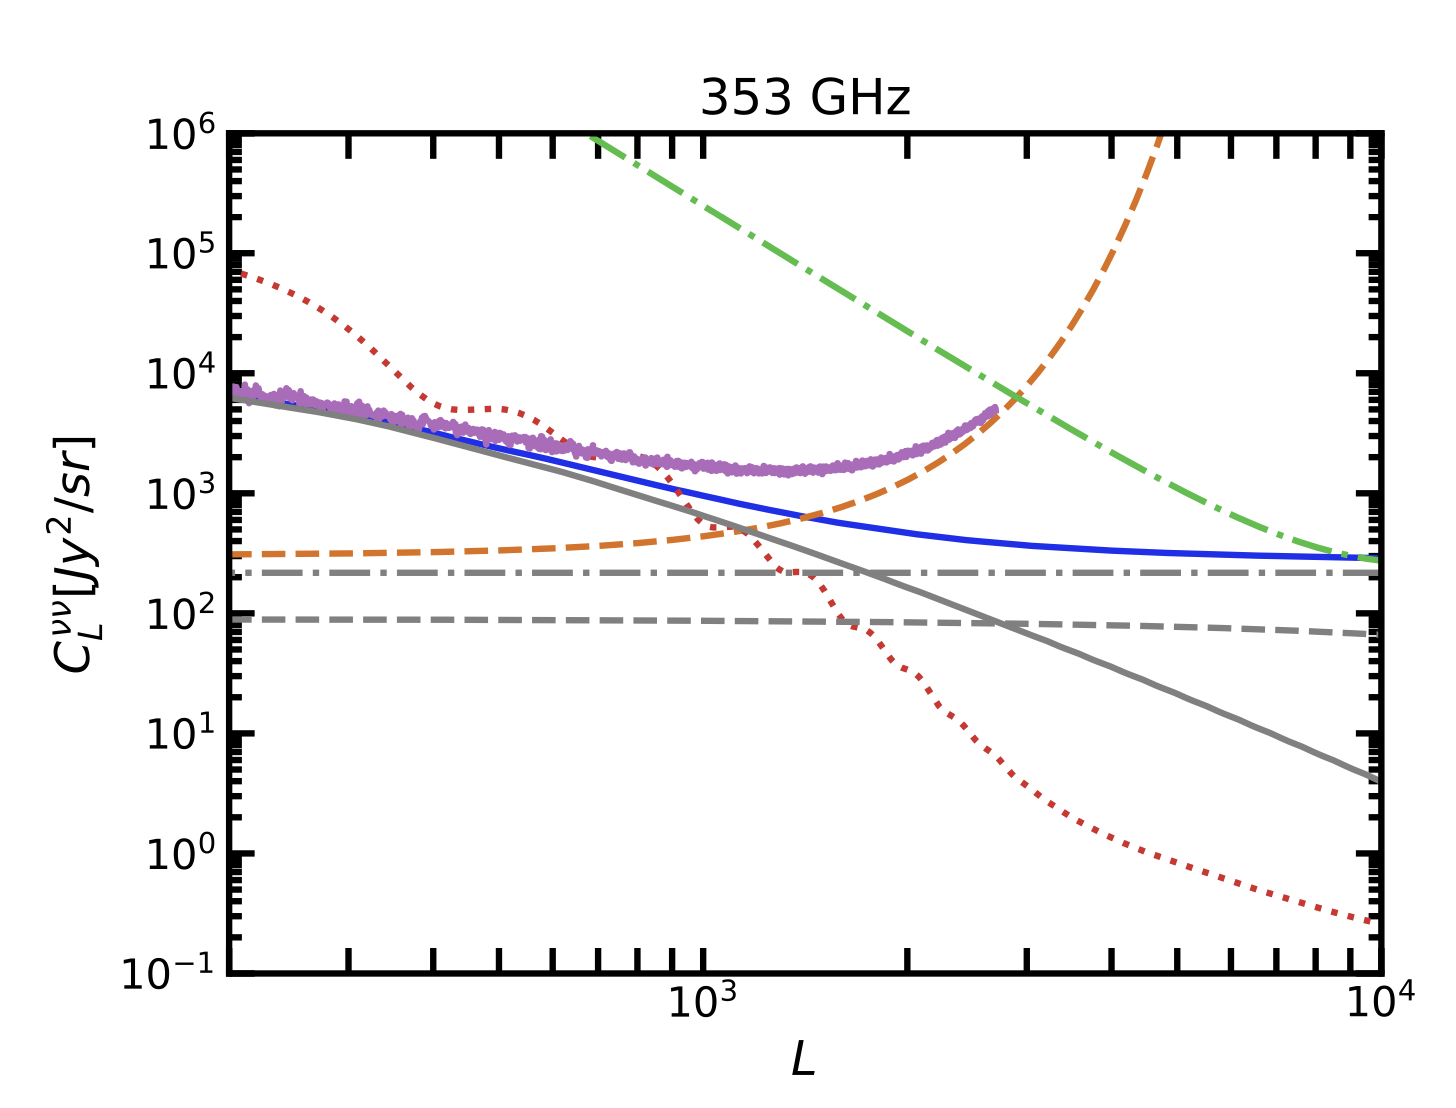

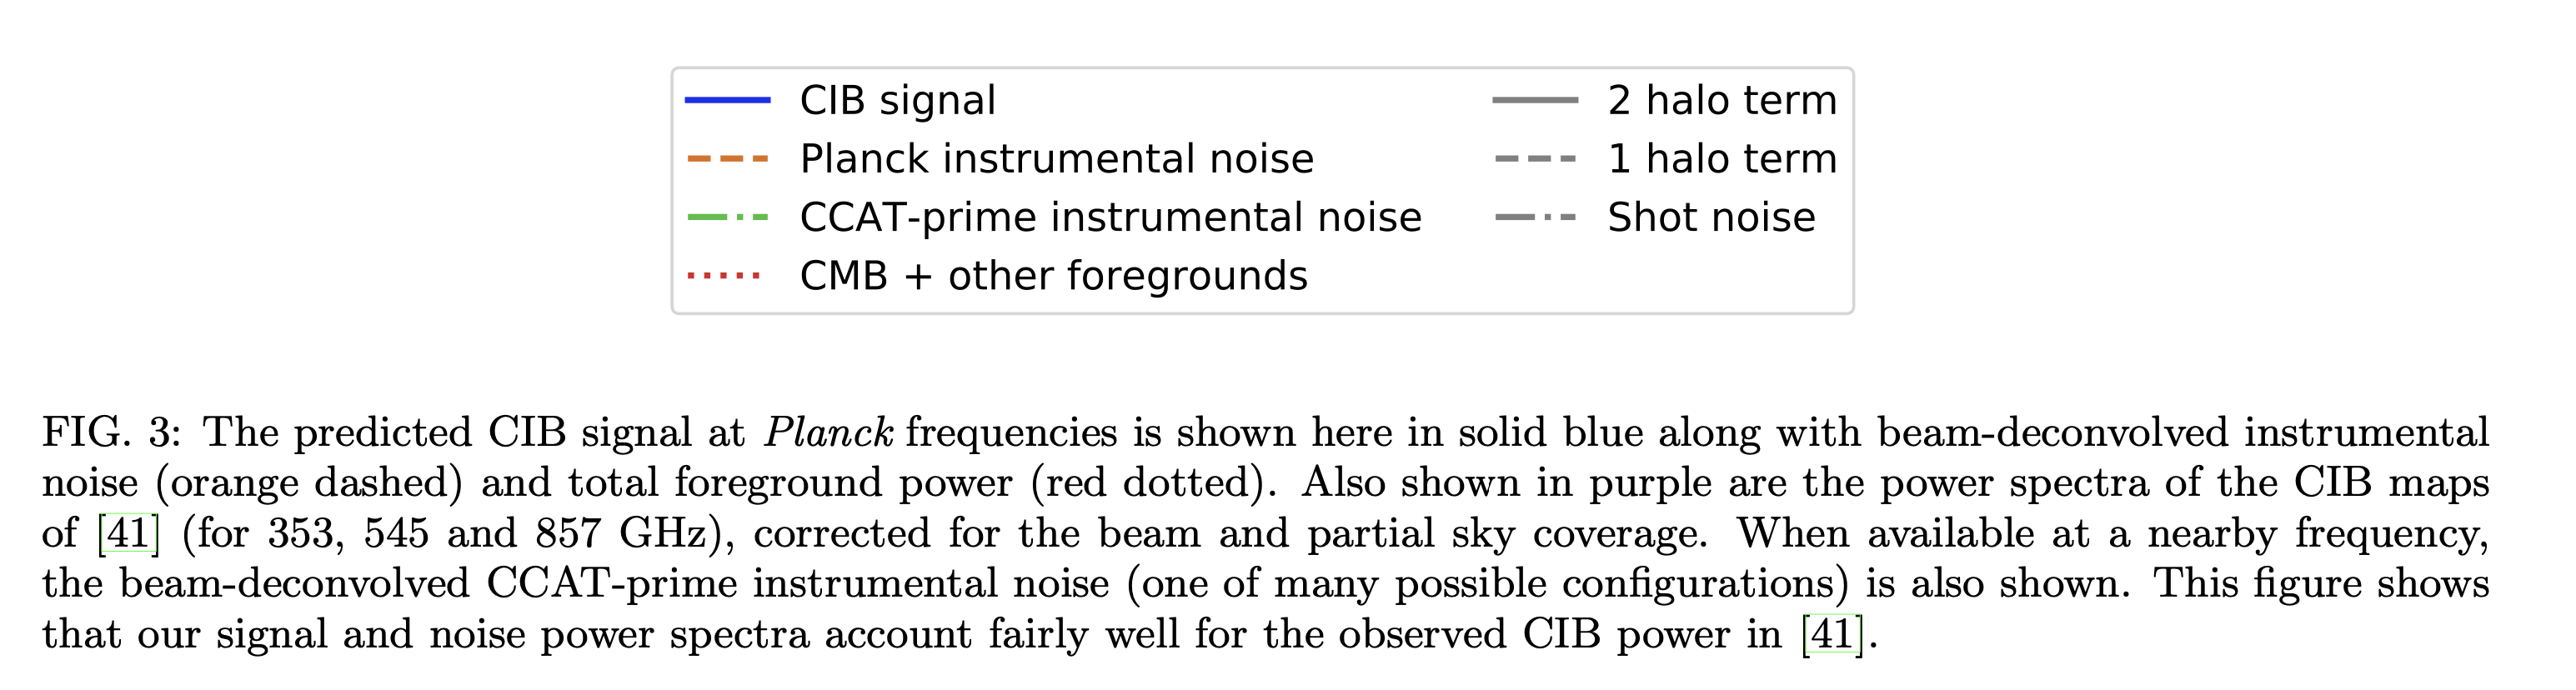

Ref 41 is D. Lenz, O. Dor ́e, and G. Lagache, ApJ 883, 75 (2019), 1905.00426.
https://arxiv.org/pdf/1905.00426.pdf

The CIB power spectrum plot from the websky paper https://arxiv.org/pdf/2001.08787.pdf

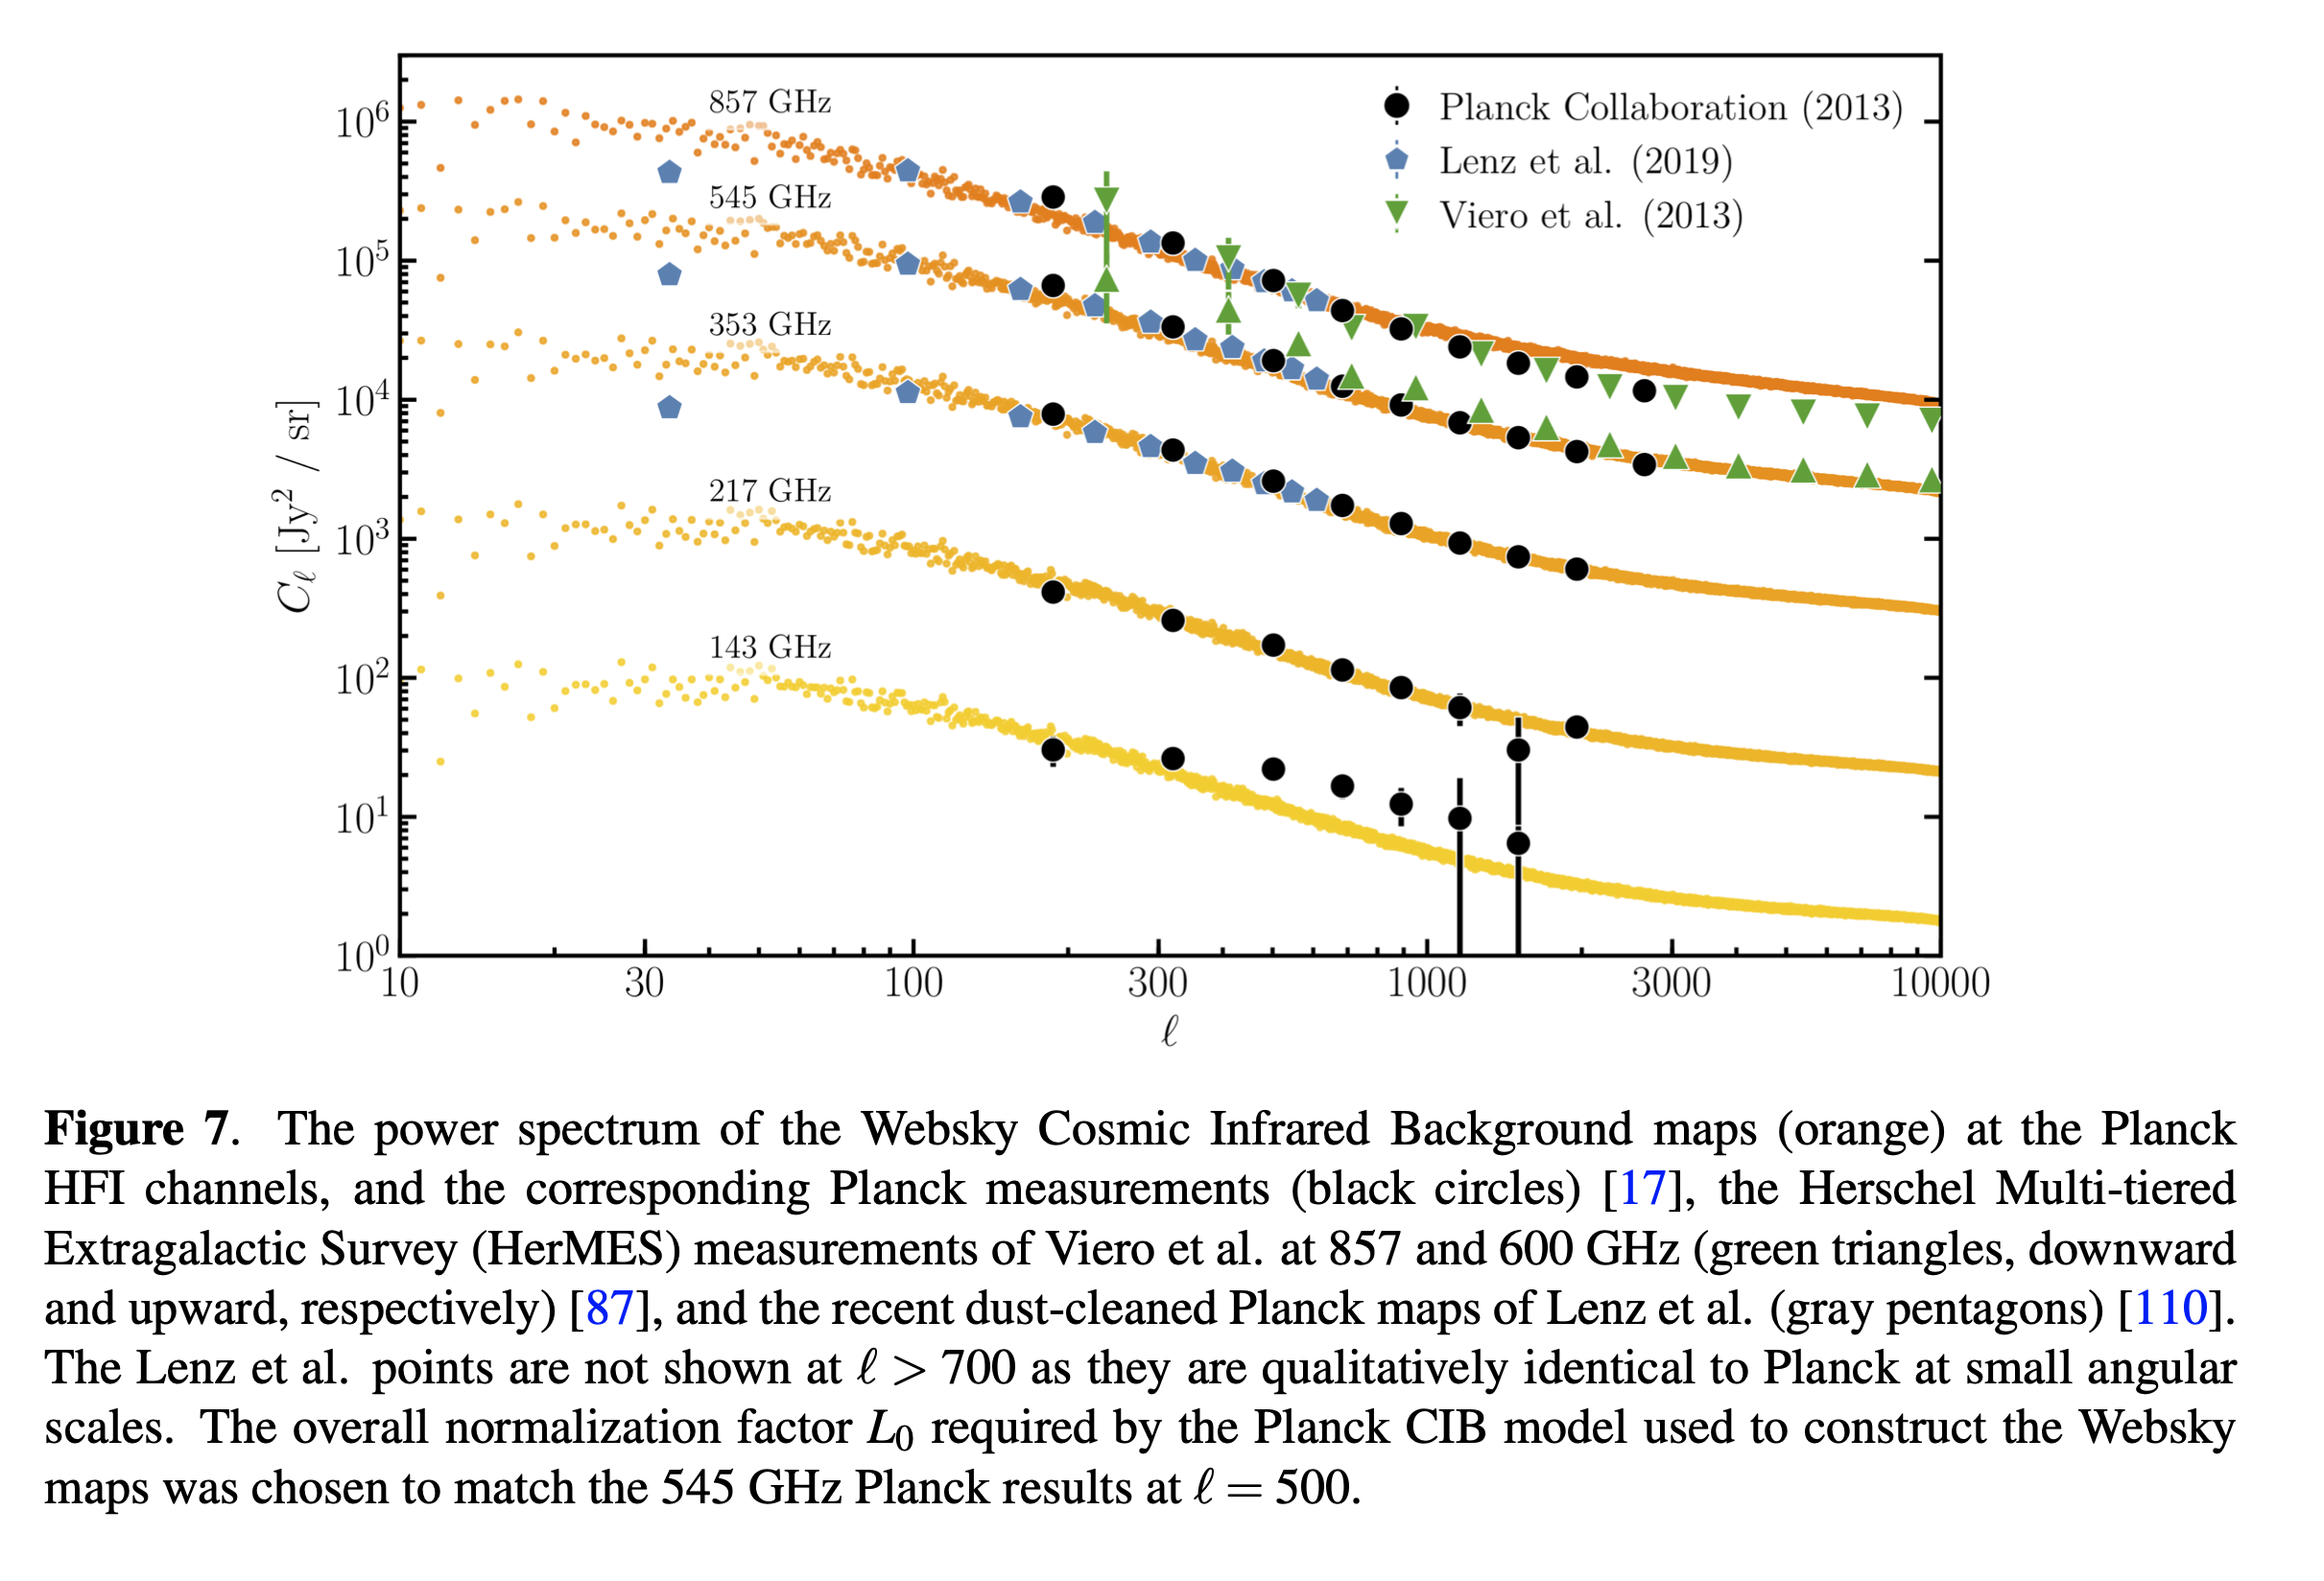

The Planck measurments here are different they are from Planck Collaboration, P. A. R. Ade, N. Aghanim, C. Armitage-Caplan, M. Arnaud, M. Ashdown et al.,
Planck 2013 results. XXX. Cosmic infrared background measurements and implications for star formation, A&A 571 (2014) A30 [1309.0382].
https://arxiv.org/pdf/1309.0382.pdf


CCL-class_sz-Fiona/Mat benchmark computation by running: <br>
$ python compute_and_plot_cib_simple.py -param_name 'h' -p_val '[0.6711]' -output 'cib_cib_1h,cib_cib_2h' -plot_cib_cib yes -save_figure yes -mode run

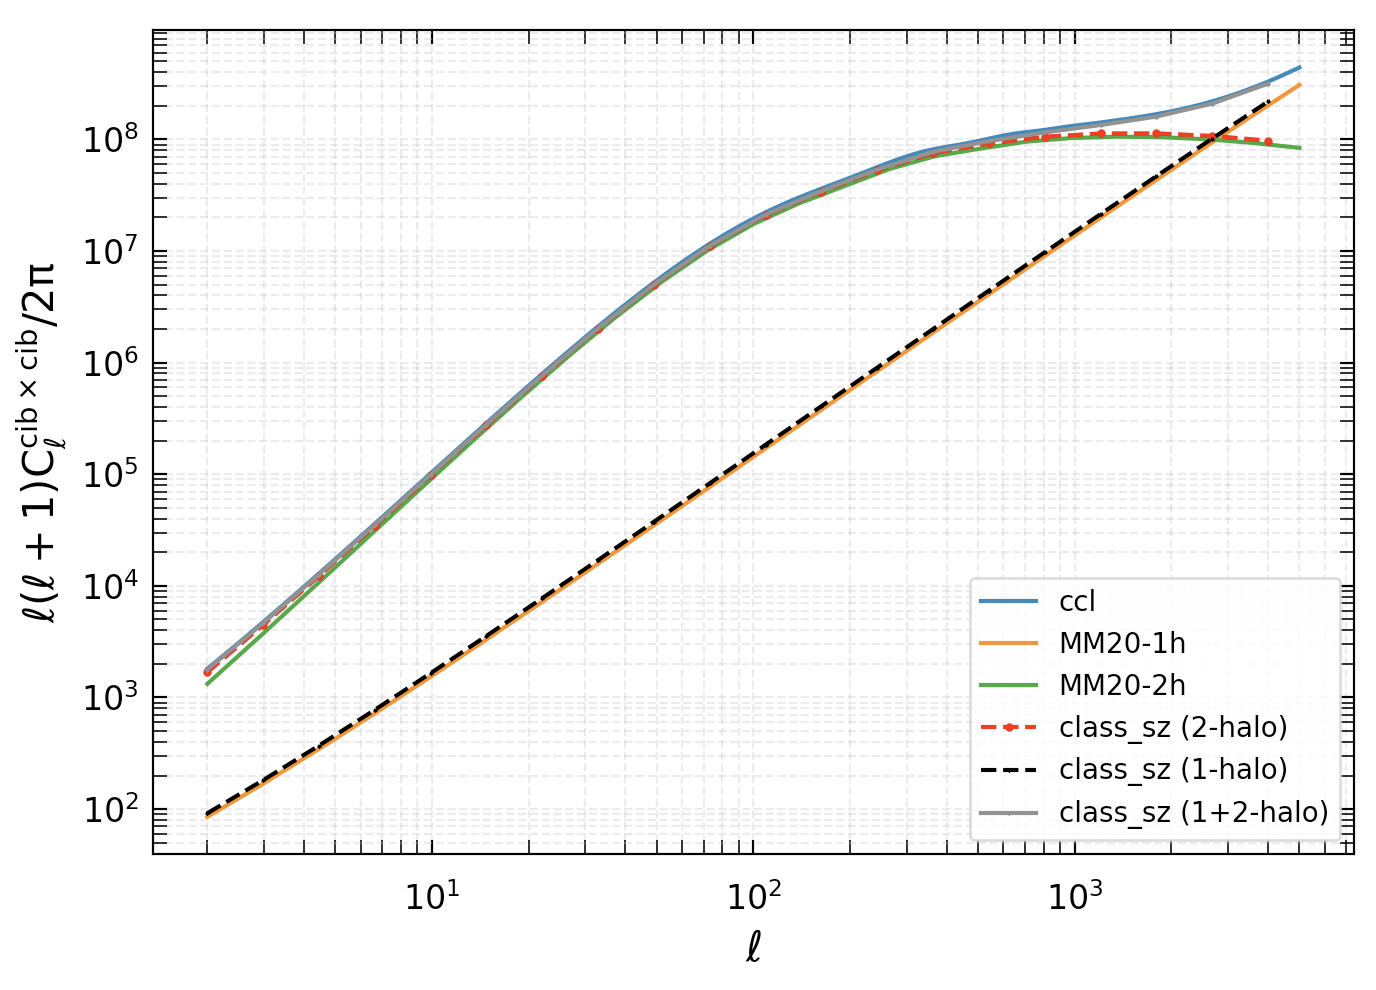

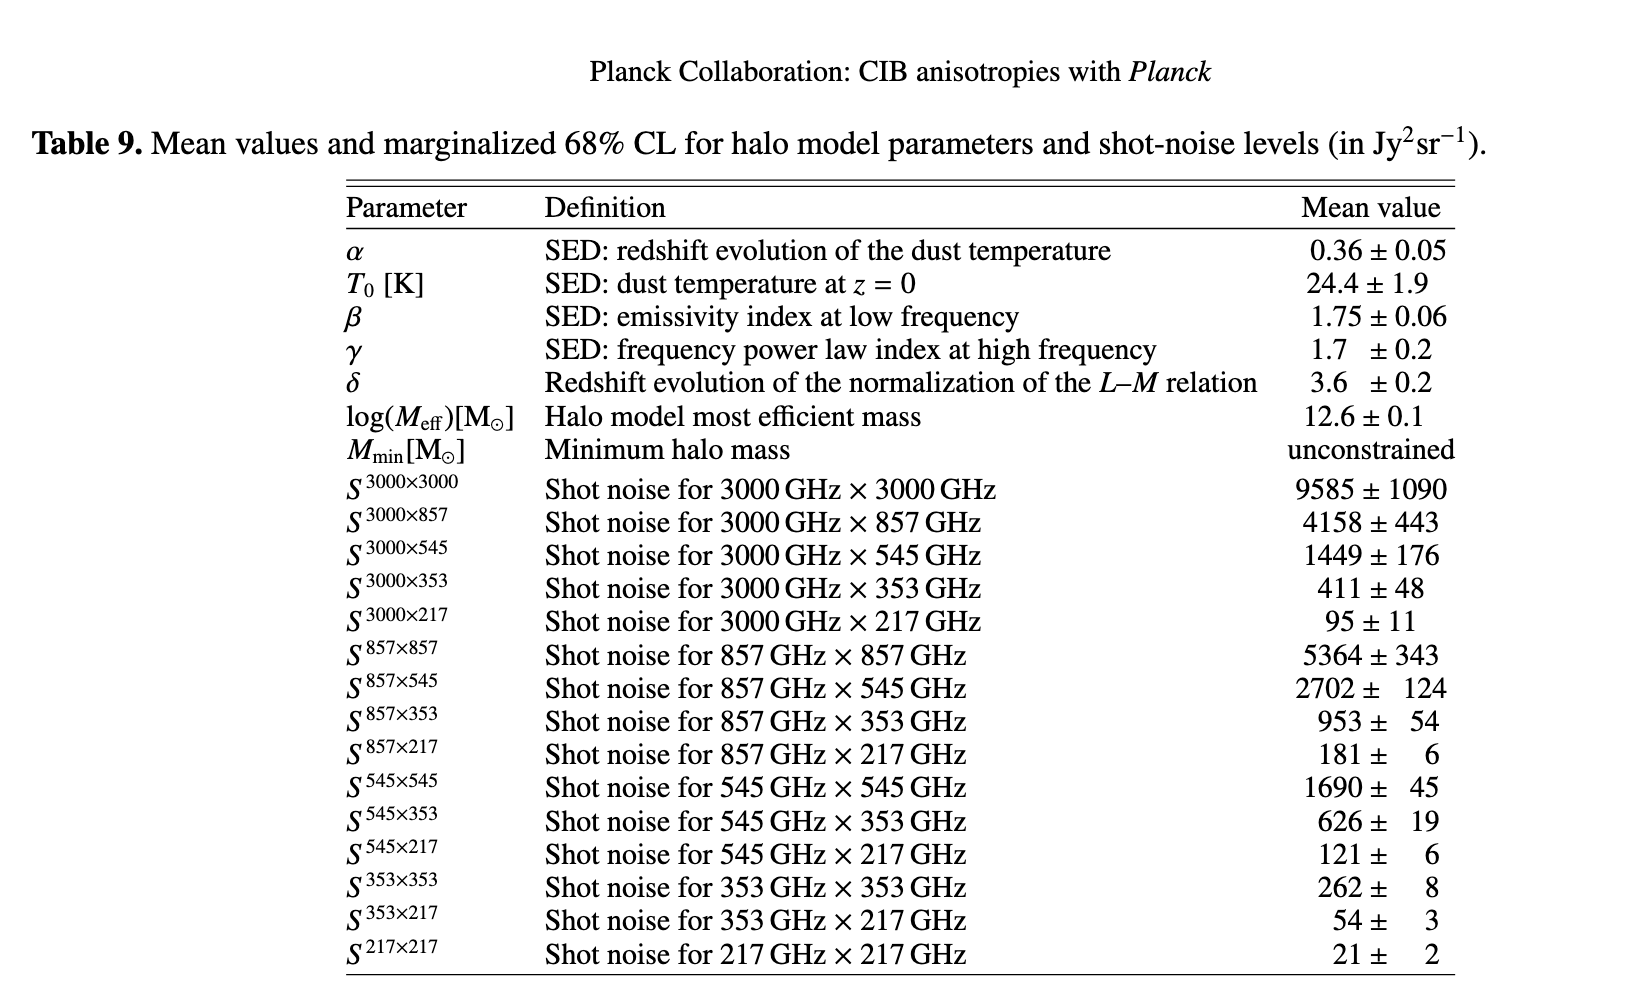